# Conditional GAN

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/07/13<br>
**Last modified:** 2021/07/15<br>
**Description:** Training a GAN conditioned on class labels to generate handwritten digits.

Generative Adversarial Networks (GANs) let us generate novel image data, video data,
or audio data from a random input. Typically, the random input is sampled
from a normal distribution, before going through a series of transformations that turn
it into something plausible (image, video, audio, etc.).

However, a simple [DCGAN](https://arxiv.org/abs/1511.06434) doesn't let us control
the appearance (e.g. class) of the samples we're generating. For instance,
with a GAN that generates MNIST handwritten digits, a simple DCGAN wouldn't let us
choose the class of digits we're generating.
To be able to control what we generate, we need to _condition_ the GAN output
on a semantic input, such as the class of an image.

In this example, we'll build a **Conditional GAN** that can generate MNIST handwritten
digits conditioned on a given class. Such a model can have various useful applications:

* let's say you are dealing with an
[imbalanced image dataset](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data),
and you'd like to gather more examples for the skewed class to balance the dataset.
Data collection can be a costly process on its own. You could instead train a Conditional GAN and use
it to generate novel images for the class that needs balancing.
* Since the generator learns to associate the generated samples with the class labels,
its representations can also be used for [other downstream tasks](https://arxiv.org/abs/1809.11096).

Following are the references used for developing this example:

* [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)
* [Lecture on Conditional Generation from Coursera](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/conditional-generation-inputs-2OPrG)

If you need a refresher on GANs, you can refer to the "Generative adversarial networks"
section of
[this resource](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/r-3/232).

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [6]:
!pip install -q git+https://github.com/tensorflow/docs

## Imports

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio
import pandas as pd
import os

## Constants and hyperparameters

In [39]:
batch_size = 64
num_channels = 3 
# num_channels = 1 # replace to 3 
num_classes = 4
image_size = 28
# image_size = 28 # replace to 128
latent_dim = 128

## Loading the MNIST dataset and preprocessing it

In [31]:
# Преобразовать все картинки в разрешение 128*128*3
x_train.shape

(60000, 28, 28)

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Datasets/artworks.zip'

In [60]:
# как грузил для классификации - не работает
local_download_path='/content/pictures/artworks'
for filename in os.listdir(local_download_path):
    if filename.endswith("jpg"): 
        # Your code comes here such as 
        img = keras.preprocessing.image.load_img(local_download_path+'/'+filename, target_size=(100,100))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis


In [75]:
img_array.shape #грузит только 1 картинку, в виде тензора

TensorShape([1, 100, 100, 3])

In [78]:
#загрузить картинки и классы. перевести все в numpay array - НЕ РАБОТАЕТ
# способ загрузки скопом из папки (создает батчи)
art_pics = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/pictures/",
    # subset="training",
    # seed=1337,
    image_size=(28,28),
    # batch_size=batch_size,
)

Found 8683 files belonging to 1 classes.


In [79]:
art_pics.size()

AttributeError: ignored

In [ ]:
art_pics.as_numpy_iterator().next()

In [14]:
# ЭТО РАБОЧИЙ СПОСОБ
from tensorflow.keras.preprocessing.image import img_to_array, load_img

array = []
path='/content/pictures/artworks'

files = os.listdir(path)

for i in files:
    if i.endswith("jpg"): 
        # загружаем изображения, сразу изменяем размер и переводим в одноканальный формат
        img = load_img(f'{path + "/" + i}', target_size=(28, 28), color_mode='rgb')
        
        # преобразовываем изображение в матрицу и сразу нормируем на 255
        img = img_to_array(img, dtype='float32')/255.
        # собираем все в один список 
        array.append(img)
        
        # возвращаем np.array
np.array(array)

array([[[[0.9529412 , 0.3529412 , 0.08627451],
         [0.8117647 , 0.2627451 , 0.02352941],
         [0.85882354, 0.26666668, 0.09019608],
         ...,
         [0.73333335, 0.1882353 , 0.03529412],
         [0.7019608 , 0.22745098, 0.05098039],
         [0.42352942, 0.16862746, 0.09803922]],

        [[0.9490196 , 0.38431373, 0.14509805],
         [0.95686275, 0.35686275, 0.13333334],
         [0.93333334, 0.37254903, 0.15294118],
         ...,
         [0.31764707, 0.15686275, 0.03921569],
         [0.7372549 , 0.24313726, 0.01568628],
         [0.6039216 , 0.13725491, 0.05882353]],

        [[0.90588236, 0.42745098, 0.16470589],
         [0.89411765, 0.32156864, 0.12156863],
         [0.8862745 , 0.22745098, 0.05098039],
         ...,
         [0.17254902, 0.11764706, 0.07450981],
         [0.3254902 , 0.12156863, 0.02745098],
         [0.75686276, 0.16862746, 0.03137255]],

        ...,

        [[0.6431373 , 0.5254902 , 0.32941177],
         [0.24705882, 0.25490198, 0.20392157]

In [15]:
np.array(array).shape
art_pics=np.array(array)

In [16]:
art_pics.min(), art_pics.max()

(0.0, 1.0)

In [89]:
# проверить порядок файлов
artnames_list=[]
for i in files:
    if i.endswith("jpg"): 
      artnames_list.append(i)

pd.DataFrame(artnames_list).to_csv('files_order.csv')
artnames_list

In [17]:
# нужно расставить классы в том же порядке, что в файле art_pics - выше проверили, что все в том же порядке
all_labels = pd.read_csv('/content/art_classes.csv')
all_labels = all_labels.to_numpy()

In [18]:
all_labels.shape

(8683, 4)

In [19]:
# НАМ НЕ НУЖНО ОБЪЯДИНЯТЬ
# We'll use all the available examples from both the training and test
# sets. 
# (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# all_digits = np.concatenate([x_train, x_test])
# all_labels = np.concatenate([y_train, y_test])


# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
# art_pics = art_pics / 255.0
# art_pics = np.reshape(art_pics, (-1, 180, 180, num_channels))
# переводит класс в столбцы 0 и 1 (типа one-hot encoder). Не нужно, так как уже в правильном формате
# all_labels = keras.utils.to_categorical(all_labels, num_classes) 

# переводим все в формат как картины -float32
all_labels = all_labels.astype("float32")

# Create tf.data.Dataset. 
#Соединяют картинки с лейблами
dataset = tf.data.Dataset.from_tensor_slices((art_pics, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {art_pics.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (8683, 28, 28, 3)
Shape of training labels: (8683, 4)


In [20]:
type(all_labels[0][1])

numpy.float32

In [21]:
type(art_pics[0][1][1][1])

numpy.float32

In [63]:
type(all_digits)

numpy.ndarray

In [35]:
pd.DataFrame(all_labels).sum(axis=1).describe() # классы нужны np array в виде столбцов 0/1. В каждой строке только в одном столбце 1. 

count    70000.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

In [66]:
all_digits.shape #картинки нужны в виде np array 

(70000, 28, 28, 1)

## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the class labels. We will have to add the number of classes to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).

In [48]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

132 7


## Creating the discriminator and generator

The model definitions (`discriminator`, `generator`, and `ConditionalGAN`) have been
adapted from [this example](https://keras.io/guides/customizing_what_happens_in_fit/).

In [182]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)), #3 - for RGB. Должно быть в скобках, так как считывается tuple'ом. 
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        #ГДЕ ЗАДАЮТСЯ РАЗМЕРЫ ВЫХОДНОГО ИЗОБРАЖЕНИЯ? 7*7?
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [89]:
dataset

<BatchDataset shapes: ((None, 28, 28, 3), (None, 4)), types: (tf.float32, tf.float32)>

In [180]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 6468)              860244    
                                                                 
 leaky_re_lu_68 (LeakyReLU)  (None, 6468)              0         
                                                                 
 reshape_12 (Reshape)        (None, 7, 7, 132)         0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 14, 14, 128)      270464    
 Transpose)                                                      
                                                                 
 leaky_re_lu_69 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 28, 28, 128)      262272    
 Transpose)                                              

## Creating a `ConditionalGAN` model

In [175]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## Training the Conditional GAN

In [176]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
) 

cond_gan.fit(dataset, epochs=20)

Epoch 1/20
136/136 [==============================] - 5s 25ms/step - g_loss: 1.1384 - d_loss: 0.5527
Epoch 2/20
136/136 [==============================] - 3s 22ms/step - g_loss: 1.3710 - d_loss: 0.7199
Epoch 3/20
136/136 [==============================] - 3s 22ms/step - g_loss: 2.2957 - d_loss: 0.2221
Epoch 4/20
136/136 [==============================] - 3s 22ms/step - g_loss: 2.4743 - d_loss: 0.1534
Epoch 5/20
136/136 [==============================] - 3s 22ms/step - g_loss: 2.2394 - d_loss: 0.2249
Epoch 6/20
136/136 [==============================] - 3s 22ms/step - g_loss: 2.5241 - d_loss: 0.1607
Epoch 7/20
136/136 [==============================] - 3s 22ms/step - g_loss: 3.2548 - d_loss: 0.0860
Epoch 8/20
136/136 [==============================] - 3s 22ms/step - g_loss: 5.1888 - d_loss: 0.0075
Epoch 9/20
136/136 [==============================] - 3s 22ms/step - g_loss: 6.5707 - d_loss: 0.0016
Epoch 10/20
136/136 [==============================] - 3s 22ms/step - g_loss: 7.1349 - d_lo

## Interpolating between classes with the trained generator

Here, we first sample noise from a normal distribution and then we repeat that for
`num_interpolation` times and reshape the result accordingly.
We then distribute it uniformly for `num_interpolation`
with the label indentities being present in some proportion.

In [177]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 10

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake

start_class = 2
end_class = 2

fake_images = interpolate_class(start_class, end_class)

In [169]:
num_interpolation = 10
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))

first_number = 0
second_number = 3

first_label = keras.utils.to_categorical([first_number], num_classes)
second_label = keras.utils.to_categorical([second_number], num_classes)
first_label = tf.cast(first_label, tf.float32)
second_label = tf.cast(second_label, tf.float32)

# Calculate the interpolation vector between the two labels.
percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
percent_second_label = tf.cast(percent_second_label, tf.float32)
interpolation_labels = (
    first_label * (1 - percent_second_label) + second_label * percent_second_label
)

# Combine the noise and the labels and run inference with the generator.
noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
fake = trained_gen.predict(noise_and_labels)

In [171]:
interpolation_labels

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[1.        , 0.        , 0.        , 0.        ],
       [0.8888889 , 0.        , 0.        , 0.11111111],
       [0.7777778 , 0.        , 0.        , 0.22222222],
       [0.6666666 , 0.        , 0.        , 0.33333334],
       [0.5555556 , 0.        , 0.        , 0.44444445],
       [0.44444442, 0.        , 0.        , 0.5555556 ],
       [0.3333333 , 0.        , 0.        , 0.6666667 ],
       [0.22222221, 0.        , 0.        , 0.7777778 ],
       [0.1111111 , 0.        , 0.        , 0.8888889 ],
       [0.        , 0.        , 0.        , 1.        ]], dtype=float32)>


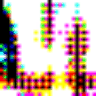

In [178]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")

In [179]:
fake_images.shape

(10, 28, 28, 3)